# High Frequency Finance Coursework II                       
<h4>K23023533 Jhao-Wei Chen</h4>

<h3>Executing Summary:</h3>
<br>
<b>1. Data Processing:</b> &nbsp; Convert the DateTime Stamp from a string into datetime format, check the data features, and then extract the data that will be used later from DataFrame as lists.
<br><br>
<b>2. Mean Reversion Strategy:</b> &nbsp; Implement the concept of mean reversion learned from 7CCMFM05 statistics in Finance to my trading strategy
<br><br>
<b>3. Backtesting:</b> &nbsp;  Construct a function for backtesting and backtest Mean Reversion Strategy on 3 different data sets. 

<h2>Part I: Trading Strategy</h2> 

***
<h3>1. Data Processing</h3>
<h4>1.1. Data Cleaning</h4>
<br>
<b>1.1.1.</b> Based on the 'Data Files: Detailed Specification' section of the Free Forex Historical Data website, add the column names: DateTime Stamp (YYYYMMDD HHMMSSNNN), Bid Quote (bid price), Ask Quote (ask price), and Volume, respectively.



In [4]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

# Import data
df = pd.read_csv('DAT_ASCII_EURGBP_T_201606.csv', names = ['DateTime Stamp', 
                                                           'Bid Quote', 
                                                           'Ask Quote', 
                                                           'Volume'], header=0)

# Transform string into time format
for i in range(len(df)):
    df.loc[i, 'DateTime Stamp'] = datetime.strptime(df.loc[i, 'DateTime Stamp'], 
                                                    '%Y%m%d %H%M%S%f')

df.head()

,DateTime Stamp,Bid Quote,Ask Quote,Volume
0,2016-06-01 00:00:03.937000,0.76777,0.76785,0
1,2016-06-01 00:00:07.937000,0.76776,0.76784,0
2,2016-06-01 00:00:20.937000,0.76778,0.76786,0
3,2016-06-01 00:00:21.687000,0.76777,0.76785,0
4,2016-06-01 00:00:31.187000,0.76777,0.76784,0


<b>1.1.2.</b> Check if volume column are all zero: It could be true because the trades are over-the-counter, which makes it hard to get the volume data from around the world, so use 0 to represent unkown trading volume.
<br>
<br>
<b>1.1.3 </b> Check if there is an abnormal situation in the limit order book such as bid quote is larger than ask quote.

In [1]:
# Check if column4 are all zeros
all_zeros = (df.iloc[:, 3] == 0).all()
print('Volumes are all zero:',all_zeros)

# Convert bid and ask quote into lists
bid_list = df['Bid Quote'].tolist()
ask_list = df['Ask Quote'].tolist()

# Calculate an average price of bid and ask quote
mid_list=[(bid + ask) / 2 for bid, ask in zip(bid_list, ask_list)]

# Check if all ask quotes are larger than bid quotes in the limit order book
count = 0 
for i in range(0,len(bid_list)):
    if bid_list[i] > ask_list[i]:
        count +=1
if count == 0:
    print("This data is from a normal limit oreder book.")
else:
    print("There are ", count, 
          " suspicious points, where ask quotes are smaller than bid quotes")

# Plot the data
plt.figure(figsize=(10,5))
price_array = np.array(mid_list)
plt.plot(price_array, label='Price', zorder=1)
plt.title('EURGBP 201606')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

NameError: name 'df' is not defined

<h4>1.2. Data Transforming</h4> 
<br>
<b>1.2.1. </b> Construct a function to transform a normal time series into intrinsic time.
<br>
<br>
<b>1.2.2. </b> Plot the prices, the local extrema and the directional changes as a quik check of the function.


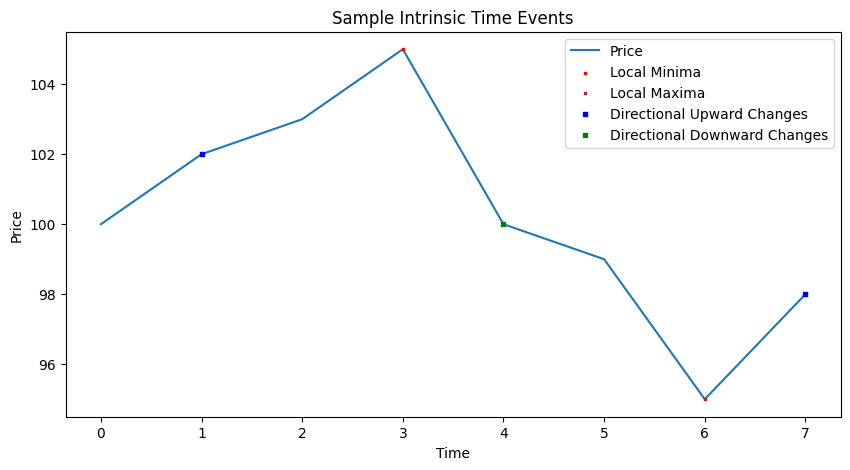

In [3]:
def intrinsic_time(quote, delta_up, delta_down):
    """
    This function implements the algorithm provided for intrinsic events in a time 
    series in slide 44 of lecture 8, and 2 else statements in the algorithm were 
    added to prevent the event from being counted repeatedly.

    Args:
        quote: the average price of bid and ask quote
        delta_up: a threshold that determines the upward trend
        delta_down: a threshold that determines the downward trend
    Returns:
        intrinsic_time_list: list of 
                    0(no significant change), 
                    1(a switch from a downward trend to an upward tren),
                   -1(a switch from a upward trend to an dowwnward tren),
                    2(a continuation of the upward trend), 
                   -2(a continuation of the downward trend)
    """
    S_ext = None  # Extremal value
    S_IE = None   # Value at which the last intrinsic event occurred
    mode = 'up'   # Initial mode assumed to be 'up'
    intrinsic_time_list = []  # Empty list to collect the result

    for i, tick in enumerate(quote):
        if i == 0: 
            S_ext = tick
            S_IE = tick
            event = 0

        elif mode == 'up':
            if tick - S_ext >= delta_up:
                mode = 'down'
                S_ext = tick
                S_IE = tick
                event = 1
            elif tick < S_ext:
                S_ext = tick
                if S_IE - S_ext >= delta_down:
                    S_IE = tick
                    event = -2 
                else: 
                    event = 0
            # Else statement is added to prevent event from being counted repeatedly
            else: 
                event = 0
            
        elif mode == 'down':
            if S_ext - tick >= delta_down:
                mode = 'up'
                S_ext = tick
                S_IE = tick
                event = -1 
            elif tick > S_ext:
                S_ext = tick
                if tick - S_IE >= delta_up:
                    S_IE = tick
                    event = 2  
                else: 
                    event = 0
            # Else statement is added to prevent event from being counted repeatedly
            else: 
                event = 0
        intrinsic_time_list.append(event)   
    return intrinsic_time_list


# Create a sample for plotting
sample_price_list = [100,102,103,105,100,99,95,98]
sample_intrinsic_time = intrinsic_time(sample_price_list, 2, 2)

# Convert lists to numpy arrays for better handling of indices
event_array = np.array(sample_intrinsic_time)
price_array = np.array(sample_price_list)

# Transform intrinsic time to extrema and directional changes
max_indices = np.where(event_array == 2)[0]  # Collect 2
min_indices = np.where(event_array == -2)[0]  # Collect -2
directional_upward_indices = np.where(event_array == 1)[0]  # Collect 1
directional_downward_indices = np.where(event_array == -1)[0]  # Collect -1

# Plot the prices, the local extrema and the directional changes
plt.figure(figsize=(10, 5))
plt.plot(price_array, label='Price', zorder=1)
plt.scatter(max_indices, price_array[max_indices], color='red', marker='s', 
            zorder=2, label='Local Minima', s=1)
plt.scatter(min_indices, price_array[min_indices], color='brown', marker='s', 
            zorder=2, label='Local Maxima', s=1)
plt.scatter(directional_upward_indices, price_array[directional_upward_indices], 
            color='blue', marker='s', zorder=3, label='Directional Upward Changes'
            , s=10)
plt.scatter(directional_downward_indices, price_array[directional_downward_indices],
            color='green', marker='s', zorder=3, 
            label='Directional Downward Changes', s=10)

plt.title('Sample Intrinsic Time Events')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

<h3>2. Mean Reversion Strategy</h3>
<h4>2.1. Constrcut a function applying the Mean Reversion Strategy.</h4>
<br>

Pseudo Code of the Mean Reversion strategy: <br> <br>
<b>if</b> <em>first tick</em> <b>then </b> <br>
    &nbsp;&nbsp;&nbsp;<em>transaction type &larr; close </em> <br>
    &nbsp;&nbsp;&nbsp;<em>position &larr; long </em> <br>
    &nbsp;&nbsp;<b> return</b> <em>None</em> <br>

<b>elif</b> <em>trend is upward</em> <b>then </b> <br>
    &nbsp;&nbsp;&nbsp;<b>if</b> <em>transaction type is not close</em> <b>then </b> <br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<em>transaction type &larr; close </em> <br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<em>if</em> <em>position is short</em> <b>then</b> <br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<em>position &larr; short</em> <br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<b>return</b> <em>(transaction type, position, time)</em><br>
    &nbsp;&nbsp;&nbsp;<em>transaction type &larr; open </em> <br>
    &nbsp;&nbsp;&nbsp;<em>position &larr; long </em> <br>
    &nbsp;&nbsp;<b> return</b> <em>(transaction type, position, time)</em> <br>

<b>elif</b> <em>trend is downward</em> <b>then </b> <br>
    &nbsp;&nbsp;&nbsp;<b>if</b> <em>transaction type is not close</em> <b>then </b> <br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<em>transaction type &larr; close </em> <br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<em>if</em> <em>position is long</em> <b>then</b> <br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<em>position &larr; long</em> <br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<b>return</b> <em>(transaction type, position, time)</em><br>
    &nbsp;&nbsp;&nbsp;<em>transaction type &larr; open </em> <br>
    &nbsp;&nbsp;&nbsp;<em>position &larr; short </em> <br>
    &nbsp;&nbsp;<b> return</b> <em>(transaction type, position, time)</em> <br>

<b>elif</b> <em>local maximum</em> <b>then </b> <br>
    &nbsp;&nbsp;&nbsp;<b>if</b> <em>transaction type is open and position is long</em> <b>then </b> <br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<em>transaction type &larr; close</em> <br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<em>position &larr; long</em> <br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<b>return</b> <em>(transaction type, position, time)</em><br>

<b>elif</b> <em>local minimum</em> <b>then </b> <br>
    &nbsp;&nbsp;&nbsp;<b>if</b> <em>transaction type is open and position is short</em> <b>then </b> <br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<em>transaction type &larr; close</em> <br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<em>position &larr; short</em> <br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<b>return</b> <em>(transaction type, position, time)</em>

[('open', 'long', 1), ('close', 'long', 3), ('open', 'short', 4), ('close', 'short', 6)]


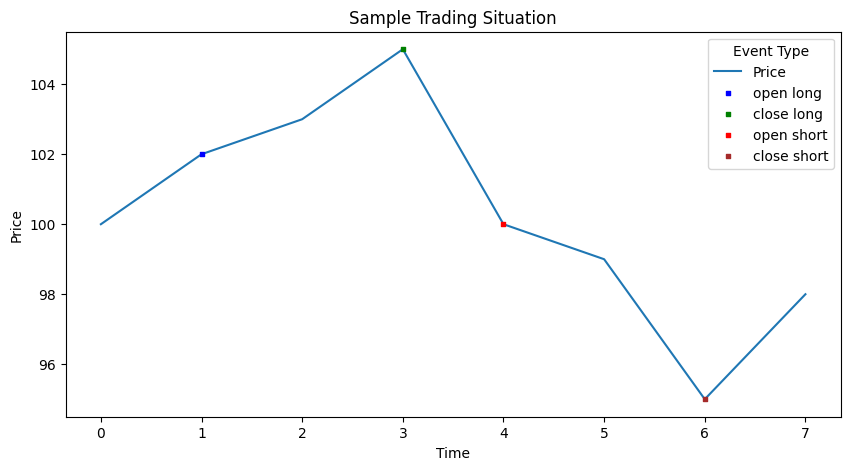

In [9]:
def mean_reversion_strategy(dc_events):
    """
    This function implements the concept of mean reversion learned from 7CCMFM05 
    statistics in Finance.

    Args:
        dc_events: intrinsic time list
    Returns:
        trade_list: list of tuples: (open/close, long/short, index)
    """
    # Opening a short position means to sell and closing a short position means to buy
    transaction_type = 'close'   # 'open', 'close'
    position = 'long' # 'long', 'short' 
    trade_list = []

    for i, event in enumerate(dc_events):
        # If directional change is upward, open a long position
        if event == 1 :
            # If the position haven't closed, close it first
            if transaction_type == 'open': 
                if position == 'short':
                    transaction_type = 'close'
                    position = 'short' 
                    trade_list.append((transaction_type, position, i))
            # Open a long position    
            transaction_type = 'open'
            position = 'long'
            trade_list.append((transaction_type, position, i))
            
        # If directional change is downward, open a short position
        elif event == -1:
            # If the position haven't closed, close it first
            if transaction_type == 'open': 
                if position == 'long':
                    transaction_type = 'close'
                    position = 'long'
                    trade_list.append((transaction_type, position, i))
            # Open a short position
            transaction_type = 'open'
            position = 'short'
            trade_list.append((transaction_type, position, i))

        # If it is the first local maxima, close the position
        elif event == 2:
            # Close the position
            if transaction_type == 'open':
                if position == 'long':
                    transaction_type = 'close'
                    position = 'long'
                trade_list.append((transaction_type, position, i))
        
        # If it is the first local minma, close the position
        elif event == -2:
            # Close the position
            if transaction_type == 'open':
                if position == 'short':
                    transaction_type = 'close'
                    position = 'short'
                trade_list.append((transaction_type, position, i))
    # Cancel the trade if it is the last one, as all positions should be closed 
    # at the end of the trading period
    if trade_list[-1][0] == 'open':
        trade_list.pop()
    return trade_list

# Create a sample data set and trading sample by using mean reversion strategy
sample_price_list = [100,102,103,105,100,99,95,98]
sample_intrinsic_time = intrinsic_time(sample_price_list, 2, 2)
sample_trading_situation = mean_reversion_strategy(sample_intrinsic_time)
print(sample_trading_situation)

# Data setup from previous description
fig, ax = plt.subplots(figsize=(10, 5))

# Line plot for the prices
ax.plot(price_array, label='Price', zorder=1)
# Setting of action scatter plots
action_markers = {
    ('open', 'long'): ('blue', 's', 10),  # Directional Upward Changes
    ('close', 'long'): ('green', 's', 10),  # Directional Downward Changes
    ('open', 'short'): ('red', 's', 10),  # Local Minima
    ('close', 'short'): ('brown', 's', 10)  # Local Maxima
}
# Plot trading points
for action, position, time in sample_trading_situation:
    color, marker, size = action_markers[(action, position)]
    ax.scatter(time, price_array[time], color=color, marker=marker, zorder=2, 
               label=f'{action} {position}', s=size)
ax.set_title('Sample Trading Situation')
ax.set_xlabel('Time')
ax.set_ylabel('Price')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), title='Event Type')

plt.show()

<h2>Part II: Testing your strategy</h2> 

***
<h3>3. Backtesting</h3>
<h4>3.1. Construct backtesting funtion and backtest on the sample data set</h4>

In [5]:
def backtest(trade_list, bid_list, ask_list):
    """
    This function backtest strategies by 6 metrics.

    Args:
        trade_list: list of tuples: (open/close, long/short, index)
        bid_list: bid price list 
        ask_list: ask price list 
    Returns:
        total return: float
        return rate: float
        win rate: float
        average profit and loss: float
        total trades: int
        profitable trades: int

    """
    cash_flow = 0.0
    total_return = 0.0
    investment = 0.0
    profitable_trades = 0
    return_list = []
    for trade in trade_list:
        transaction_type, position, index = trade
        # Open a long position
        if transaction_type == 'open' and  position == 'long':
            last_cash_flow = cash_flow
            cash_flow -= ask_list[index]
        # Open a short Position
        elif transaction_type == 'open' and  position == 'short':
            last_cash_flow = cash_flow
            cash_flow += bid_list[index]
        # Close a short position
        elif transaction_type == 'close' and  position == 'short':
            cash_flow -= ask_list[index]
            if last_cash_flow < cash_flow:
                profitable_trades+=1
        # Close a long position
        elif transaction_type == 'close' and  position == 'long':
            cash_flow += bid_list[index]
            if last_cash_flow < cash_flow:
                profitable_trades+=1
                
        # Check if it is the max loss value
        if cash_flow < investment:
            investment = cash_flow
            
    # Set the max loss value as the minimum investment 
    investment = abs(investment)

    # Compute and return 6 metrics 
    return {
    'total return': cash_flow, 
    'return rate': cash_flow / investment,
    'win rate': profitable_trades * 2 / len(trade_list),
    'average profit and loss': cash_flow * 2 / len(trade_list),
    'total trades': int(len(trade_list) / 2),
    'profitable trades': profitable_trades,
    }
    
# Create a sample data set and trading sample by using mean reversion strategy
sample_price_list = [100,102,103,105,100,99,95,98]
sample_intrinsic_time = intrinsic_time(sample_price_list, 2, 2)
sample_trading_situation = mean_reversion_strategy(sample_intrinsic_time)
# Backtest on the sample dataset
print(backtest(sample_trading_situation, sample_price_list, sample_price_list))

{'total return': 8.0, 'return rate': 0.0784313725490196, 'win rate': 1.0, 'average profit and loss': 4.0, 'total trades': 2, 'profitable trades': 2}


<h4>3.3. Backtesting on the different dataset: EURGBP 201606 </h4>

In [6]:
# Backtest on the dataset: EURGBP 201606, with different DC threshold 
# Threshold = 0.01
trade_list = mean_reversion_strategy(intrinsic_time(mid_list, 1e-2, 1e-2))
print(backtest(trade_list, bid_list, ask_list))
# Threshold = 0.001
trade_list = mean_reversion_strategy(intrinsic_time(mid_list, 1e-3, 1e-3))
print(backtest(trade_list, bid_list, ask_list))
# Threshold = 0.0001
trade_list = mean_reversion_strategy(intrinsic_time(mid_list, 1e-4, 1e-4))
print(backtest(trade_list, bid_list, ask_list))
# Threshold = 0.00001
trade_list = mean_reversion_strategy(intrinsic_time(mid_list, 1e-5, 1e-5))
print(backtest(trade_list, bid_list, ask_list))

{'total return': 0.01503999999999961, 'return rate': 0.018533808180014055, 'win rate': 0.4583333333333333, 'average profit and loss': 0.0006266666666666504, 'total trades': 24, 'profitable trades': 11}
{'total return': -0.688579999999998, 'return rate': -0.45256357171494027, 'win rate': 0.3856312731114633, 'average profit and loss': -0.0003637506603275214, 'total trades': 1893, 'profitable trades': 730}
{'total return': -14.19323000000024, 'return rate': -0.9446346446945453, 'win rate': 0.2546265556633808, 'average profit and loss': -0.00024164036297393874, 'total trades': 58737, 'profitable trades': 14956}
{'total return': -74.44274000000266, 'return rate': -0.9889513595720834, 'win rate': 0.0128010332706367, 'average profit and loss': -0.00014015943396049294, 'total trades': 531129, 'profitable trades': 6799}


<h4>3.3. Backtesting on the different dataset: EURUSD 201912 </h4>

In [7]:
# Import data for backtesting
df = pd.read_csv('DAT_ASCII_EURUSD_T_201912.csv', 
                 names = ['DateTime Stamp', 'Bid Quote', 
                          'Ask Quote', 'Volume'], header=0)

# Transform string into time format
for i in range(len(df)):
    df.loc[i, 'DateTime Stamp'] = datetime.strptime(df.loc[i, 'DateTime Stamp'], 
                                                    '%Y%m%d %H%M%S%f')

# Convert bid and ask quote into lists
bid_list = df['Bid Quote'].tolist()
ask_list = df['Ask Quote'].tolist()

# Calculating an average price of bid and ask quote
mid_list=[(bid + ask) / 2 for bid, ask in zip(bid_list, ask_list)]

# Backtest on different datasets with different DC threshold 
# Threshold = 0.01
trade_list = mean_reversion_strategy(intrinsic_time(mid_list, 1e-2, 1e-2))
print(backtest(trade_list, bid_list, ask_list))
# Threshold = 0.001
trade_list = mean_reversion_strategy(intrinsic_time(mid_list, 1e-3, 1e-3))
print(backtest(trade_list, bid_list, ask_list))
# Threshold = 0.0001
trade_list = mean_reversion_strategy(intrinsic_time(mid_list, 1e-4, 1e-4))
print(backtest(trade_list, bid_list, ask_list))
# Threshold = 0.00001
trade_list = mean_reversion_strategy(intrinsic_time(mid_list, 1e-5, 1e-5))
print(backtest(trade_list, bid_list, ask_list))

{'total return': -0.007050000000000001, 'return rate': -0.006349578045771002, 'win rate': 0.0, 'average profit and loss': -0.0035250000000000004, 'total trades': 2, 'profitable trades': 0}
{'total return': -0.006420000000001647, 'return rate': -0.005676593336635811, 'win rate': 0.37222222222222223, 'average profit and loss': -3.5666666666675816e-05, 'total trades': 180, 'profitable trades': 67}
{'total return': -0.40304999999991, 'return rate': -0.2644667685907138, 'win rate': 0.39413441955193484, 'average profit and loss': -3.283503054989083e-05, 'total trades': 12275, 'profitable trades': 4838}
{'total return': -7.564249999999932, 'return rate': -0.8710088237969608, 'win rate': 0.06066879681064681, 'average profit and loss': -2.7717216058158542e-05, 'total trades': 272908, 'profitable trades': 16557}


<h4>3.4. Backtesting on the different dataset: EURJPY 201303</h4>

In [8]:
# Import data for backtesting
df = pd.read_csv('DAT_ASCII_EURJPY_T_201303.csv', 
                 names = ['DateTime Stamp', 'Bid Quote', 
                          'Ask Quote', 'Volume'], header=0)

# Transform string into time format
for i in range(len(df)):
    df.loc[i, 'DateTime Stamp'] = datetime.strptime(df.loc[i, 'DateTime Stamp'], 
                                                    '%Y%m%d %H%M%S%f')

# Convert bid and ask quote into lists
bid_list = df['Bid Quote'].tolist()
ask_list = df['Ask Quote'].tolist()

# Calculating an average price of bid and ask quote
mid_list=[(bid + ask) / 2 for bid, ask in zip(bid_list, ask_list)]

# Backtest on different datasets with different DC threshold 
# Threshold = 2
trade_list = mean_reversion_strategy(intrinsic_time(mid_list, 2, 2))
print(backtest(trade_list, bid_list, ask_list))
# Threshold = 1
trade_list = mean_reversion_strategy(intrinsic_time(mid_list, 1, 1))
print(backtest(trade_list, bid_list, ask_list))
# Threshold = 0.5
trade_list = mean_reversion_strategy(intrinsic_time(mid_list, 0.5, 0.5))
print(backtest(trade_list, bid_list, ask_list))
# Threshold = 0.1
trade_list = mean_reversion_strategy(intrinsic_time(mid_list, 0.1, 0.1))
print(backtest(trade_list, bid_list, ask_list))

{'total return': -11.130999999999986, 'return rate': -0.08248362332157563, 'win rate': 0.2, 'average profit and loss': -1.1130999999999986, 'total trades': 10, 'profitable trades': 2}
{'total return': 3.0109999999999673, 'return rate': 0.024142078255291587, 'win rate': 0.4, 'average profit and loss': 0.12043999999999869, 'total trades': 25, 'profitable trades': 10}
{'total return': -8.453999999999965, 'return rate': -0.06448561773926553, 'win rate': 0.3548387096774194, 'average profit and loss': -0.09090322580645124, 'total trades': 93, 'profitable trades': 33}
{'total return': -66.46400000000004, 'return rate': -0.3550958476695234, 'win rate': 0.35567970204841715, 'average profit and loss': -0.030942271880819387, 'total trades': 2148, 'profitable trades': 764}


<h4>3.5. Discussion of Empirical Results and Suggestion</h4>


<b>Backtest Metrics Introduction:</b> <br>
In the backtest function, six metrics represent the strategy’s performance. 'Total Return' records the overall profit and loss throughout the data set, while 'Return Rate' measures the rate of return, with the minimum investment set at the point of maximum loss during the trading period. 'Total Trades' counts the number of trades, where a trade is defined as a position that is opened and closed, and 'Profitable Trade' counts the number of trades that earn a profit. 'Win Rate' computes the rate of profitable trades, and 'Average Profit and Loss' calculates the mean return. <br>
<b>Backtest Results:</b> <br>
I used the FX tick data for the following currency pairs as my testing data sets: Euro (EUR) to British Pound (GBP) in June 2016, Euro (EUR) to Japanese Yen (JPY) in March 2013, and Euro (EUR) to United States Dollar (USD) in December 2019. <br>
<b>Threshold and Total Trade:</b> <br>
Clearly, across all datasets, as the threshold used in the intrinsic time transformation increases, so does the total number of trades. This occurs because a smaller threshold results in more directional changes and local extrema, which prompt trading. Furthermore, the scale of the threshold depends on the bid and ask prices; that is, a threshold may be small if the bid and ask prices are high, and conversely, it can be large when the bid and ask prices are low. <br>
<b>Total Return:</b> <br>
Similarly, the total return is not a standardized indicator, as its scale is also influenced by the asset's price. For instance, the bid and ask prices of the EUR to JPY exceed 100, resulting in a higher total return figure compared to the EUR to GBP, where prices are around 0.76. This introduces a bias in the total return, prompting me to use the return rate to compare the strategy’s performance across different datasets. <br>
<b>Return Rate:</b> <br>
I used the return rate to compare the performance of a strategy across different datasets. Among these datasets, the highest return rate, 2 percent, occurred on EUR to JPY in March 2013, with a threshold of 1 used in the intrinsic time transformation. However, the return rates for the other datasets are all negative, which could be improved through machine learning to determine the optimal threshold for intrinsic time transformation. <br>
<b>Win Rate:</b> <br>
As for the win rate, it is another metric for the accuracy of a trading strategy’s prediction. If the win rate is below 50 percent, it indicates that the trend does not align with the strategy’s predictions. The win rates for all datasets are below 50 percent, with some even less than 6 percent. To improve this, the strategy could be modified by introducing additional parameters to predict trends more accurately. <br>
<b>Conclusion:</b> <br>
The discussion and suggestions based on the results of backtesting the Mean Reversion strategy on three different datasets highlight three points: 
1. There is a positive relationship between the threshold for intrinsic time transformation and the total number of trades.
2. Most return rates are negative, showing poor performance of the strategy. This could potentially be improved by using machine learning to determine the optimal threshold for intrinsic time transformation.
3. All win rates are below 0.5, indicating poor accuracy of the strategy. This could be improved by introducing additional parameters to predict trends more accurately.


<h2>Reference:</h2> 
<br>
<a href="https://www.histdata.com/f-a-q/data-files-detailed-specification/" target="_blank" rel="noopener noreferrer">Data Files: Detailed Specification of Free Forex Historical Data on HistData.com</a>


<a href="https://www.academia.edu/43733707/Mean_Reversion_Trading_Strategies_and_the_Black_Swan_Events" target="_blank" rel="noopener noreferrer">Babayev, Mark and Lotun, Folakemi and Mumvenge, Goodwill Tatenda and Bhattacharyya, Ritabrata, Short Term Trading Models – Mean Reversion Trading Strategies and the Black Swan Events (February 15, 2020).</a>


<a href="https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2474755" target="_blank" rel="noopener noreferrer">Harvey, Campbell R. and Liu, Yan, Evaluating Trading Strategies (August 25, 2014).</a>